In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Utils

In [2]:
def print_current_results(epochs, Model, train_features, train_target, test_features, test_target, loss_sum, prefix = ""):
    print(prefix + "Epoch: {}, Train Error: {:.4f}%, Test Error: {:.4f}%, Loss  {:.4f}".format(epochs,
                                                                                      compute_accuracy(Model, train_features, train_target),
                                                                                      compute_accuracy(Model, test_features, test_target),
                                                                                      loss_sum))
def print_in_color(message, color = "red"):
    choices = {"green": "32", "blue": "34",
               "magenta": "35", "red": "31"}
    if message == "-h":
        return list(choices.keys())
    elif color == "":
        print(message)
    elif color in choices:
        print("\x1b[" + choices[color] + "m" + message + "\x1b[0m")
    else:
        raise ValueError("Available colors: {}, '-h' to get the list".format(choices.keys()))

# Data

Create a dataset of 1000 points with label 0 if outside the disk of radius 1/√2π and 1 inside

In [78]:
def generate_disc_set(nb):
    features = np.random.uniform(-1, 1, (nb, 2))
    target = []
    for el in features:
        target.append(int(((math.pow(el[0],2) + math.pow(el[1],2))/math.pi) < 0.2))
    return features, np.asarray(target)

In [52]:
def plot_dataset(features, target):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.title("Dataset")
    scatter = ax.scatter(features[:, 0], features[:, 1], c=target)
    legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="lower right")
    ax.add_artist(legend)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\antho\\Anaconda3\\envs\\venv_torch\\lib\\site-packages\\matplotlib\\pyplot.py'>

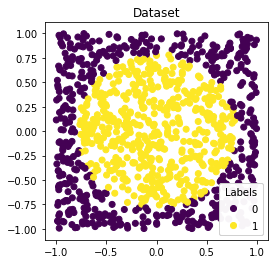

In [115]:
train_features, train_target = generate_disc_set(1000)
test_features, test_target = generate_disc_set(1000)
plot_dataset(train_features, train_target)

# Data management

In [116]:
def convert_to_one_hot_labels(features, target):
    n_values = max(target) + 1
    target_onehot = np.eye(n_values)[target]
    return target_onehot

def compute_accuracy(model, data_features, data_target):
    predicted_classes = get_inferences(model, data_features)
    nb_data_errors = sum(data_target != predicted_classes)
    return nb_data_errors/len(data_features)*100

def get_inferences(model, data_features):
    output = model.forward(data_features)
    _, predicted_classes = output
    return predicted_classes

In [153]:
get_inferences(Model, train_features)

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

# Module Class

In [95]:
# heritage module definition
class Module(object):
    def __init__(self):
        super().__init__()
        self.lr = 0
    def forward(self, *input) :
        raise NotImplementedError
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []

In [96]:
possible_types = ["Linear", "Activation", "Loss"]

# activation functions

In [176]:
# RelU activation function
class ReLU(Module):
    def __init__(self ):
        super().__init__()
        self.type = "Activation"
        self.save = 0
    def forward(self, x):
        self.save = x
        x[x < 0] = 0
        y = x
        return y
    def backward(self, x):
        y = self.save > 0
        return float(y)*x
    def print(self, color=""):
        print_in_color("\tReLU activation", color)
        return

# LeakyReLU activation function
class LeakyReLU(Module):
    def __init__(self ):
        super().__init__()
        self.type = "Activation"
        self.save = 0
        self.a = 0.01
    def forward(self, x):
        self.save = x
        neg = x < 0
        pos = x >= 0
        y = float(neg)*self.a*x + float(pos)*x
        return y
    def backward(self, x):
        neg = self.save < 0
        pos = self.save >= 0
        y = neg*self.a*x + pos*x
        return y
    def print(self, color=""):
        print_in_color("\tLeakyReLU activation", color)
        return

# sigmoid activation function
class Sigmoid(Module):
    def __init__(self, ):
        super().__init__()
        self.type = "Activation"
        self.save = 0
    def eq(x):
        return 1 / ( 1 +  x.mul(-1).exp())
    def forward(self, x):
        self.save = x
        y = eq(x)
        return y
    def backward(self, x):
        y = (eq(self.save) * (1 - eq(self.save))) * x
        return y
    def print(self, color=""):
        print_in_color("\tSigmoid activation", color)
        return

# MSE loss function

In [103]:
#MSE Loss implementation 
class LossMSE(Module):
    def __init__(self, ):
        super().__init__()
        self.type = "Loss"
    def loss(self, y, y_pred):
        loss = sum(math.pow(y_pred - y, 2))
        return loss
    def print(self, color=""):
        print_in_color("\tMSE", color)
    def grad(self, y, y_pred):
        return 2*(y_pred-y)

# Layers implementation

In [170]:
# Linear layer
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.type = "Linear"
        self.x = np.zeros(out_features)        
        self.in_features = in_features
        self.out_features = out_features
        stdv = 1. / math.sqrt(self.out_features)
        self.weight = np.random.uniform(-stdv, stdv, (self.in_features,self.out_features))
        self.bias = np.random.uniform(-stdv, stdv, (self.out_features, 1))

    def print(self, color = ""):
        msg = "\tLinear layer shape: {}".format([len(self.weight), len(self.weight[0])])
        print_in_color(msg, color)

    def print_weight(self):
        print(self.weight)

    def update(self, grad):
        lr = self.lr
        self.weight = self.weight - lr*np.transpose(self.x) * grad 
        self.bias = self.bias - lr*grad.mean(0)*1

    def backward(self, grad):
        b = grad * np.transpose(self.weight)
        self.update(grad)
        return b

    def forward(self, x):
        self.x = x
        print(np.matmul(x, self.weight) + np.transpose(np.repeat(self.bias, len(x), axis=1)))
        return np.matmul(x, self.weight) + np.transpose(np.repeat(self.bias, len(x), axis=1))

    def set_Lr(self, lr):
        self.lr = lr
        return

# Sequential architecture

In [113]:
# Sequential architecture
class Sequential(Module):
    def __init__(self, param, loss):
        super().__init__()
        self.type = "Sequential"
        self.model = param
        self.loss = loss

    def forward(self, x):
        for _object in self.model:
            x = _object.forward(x)
        return x
    
    def backward(self, y, y_pred):
        loss = self.loss.loss(y, y_pred)
        grad_pred = self.loss.grad(y, y_pred)
        for _object in reversed(self.model):
            grad_pred = _object.backward(grad_pred)
        return loss

    def print(self):
        print_color = True
        possible_colors = print_in_color("-h")
        if len(possible_colors) < len(possible_types):
            print('Not enough color available, {} more needed'.format(len(possible_types) - len(possible_colors)))
            print_color = False
        legend = ", ".join([possible_types[i] + " in " + possible_colors[i] for i in range(len(possible_types))])
        print("Model description: " + legend)
        for _object in self.model:
            if print_color:
                _object.print(possible_colors[possible_types.index(_object.type)])
            else:
                _object.print()
        if print_color:
            self.loss.print(possible_colors[possible_types.index(self.loss.type)])
        else:
            self.loss.print()

    def set_Lr(self, lr=0):
        for _object in self.model:
            if isinstance(_object, Linear):
                _object.set_Lr(lr)

# Training

In [177]:
nb_epochs = 400
batch_size = 10

# Build the model
Model = Sequential([Linear(2,128), ReLU(), Linear(128,2), ReLU()], LossMSE())
# Set the learning rate
Model.set_Lr(0.01)

# Print model's parameters
Model.print()

# Convert train_target to one hot encoding
train_target_one_hot = convert_to_one_hot_labels(train_features, train_target)

print_current_results(0, Model, train_features, train_target, test_features, test_target, 0, prefix = "Before training: ")
print("start")
test_results = []
for epochs in range(0, nb_epochs):
    loss_sum = 0
    test_results.append(get_inferences(Model, test_features))
    for b in range(train_features.size(0) // batch_size):
        print("forward")
        output = Model.forward(train_features.narrow(0, b * batch_size, batch_size))
        print("backward")
        loss = Model.backward(train_target_one_hot.narrow(0, b * batch_size, batch_size), output)
        loss_sum = loss_sum + loss.item()
    if epochs % 30 == 0:
        print_current_results(epochs + 1, Model, train_features, train_target, test_features, test_target, loss_sum)
    
        
print_current_results(epochs, Model, train_features, train_target, test_features, test_target, loss_sum, prefix = "After training: ")

Model description: Linear in green, Activation in blue, Loss in magenta
	Linear layer shape: [2, 128]
	ReLU activation
	Linear layer shape: [128, 2]
	ReLU activation
	MSE
[[-0.0410563  -0.04489064  0.06969241 ... -0.07863873 -0.0377434
   0.09908099]
 [-0.01240874 -0.08061787  0.06569549 ... -0.08377185 -0.06348599
   0.13027522]
 [ 0.03211758 -0.12483925  0.06760286 ... -0.07678111 -0.0686412
   0.14282988]
 ...
 [-0.02710886 -0.03144121  0.08989237 ... -0.04031091  0.04479055
   0.0162722 ]
 [-0.04170323 -0.00133247  0.10047834 ... -0.02193401  0.09460707
  -0.03745244]
 [ 0.0202643  -0.09465794  0.08031299 ... -0.05427435 -0.01052761
   0.08099828]]
[[0.         0.         0.06969241 ... 0.         0.         0.09908099]
 [0.         0.         0.06569549 ... 0.         0.         0.13027522]
 [0.03211758 0.         0.06760286 ... 0.         0.         0.14282988]
 ...
 [0.         0.         0.08989237 ... 0.         0.04479055 0.0162722 ]
 [0.         0.         0.10047834 ... 0. 

ValueError: too many values to unpack (expected 2)

In [37]:
def plot_result_evolution(features, results_list, number, interval):
    fig = plt.figure(figsize=(number//interval*2, number//interval*2))
    result_wanted = [result for idx, result in enumerate(results_list) if idx < number and idx%interval == 0]
    for i, result in enumerate(result_wanted):
        ax =fig.add_subplot(round(math.sqrt(len(result_wanted)))+1, round(math.sqrt(len(result_wanted))), i+1)
        plt.title("Epoch n°{}".format(i*interval))
        scatter = ax.scatter(features.numpy()[:, 0], features.numpy()[:, 1], c=result.numpy())
        legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="lower right")
        ax.add_artist(legend)

Target result


<module 'matplotlib.pyplot' from 'C:\\Users\\antho\\Anaconda3\\envs\\venv_torch\\lib\\site-packages\\matplotlib\\pyplot.py'>

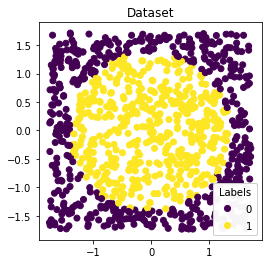

In [53]:
print("Target result")
plot_dataset(test_features, test_target)

LeakyReLU results


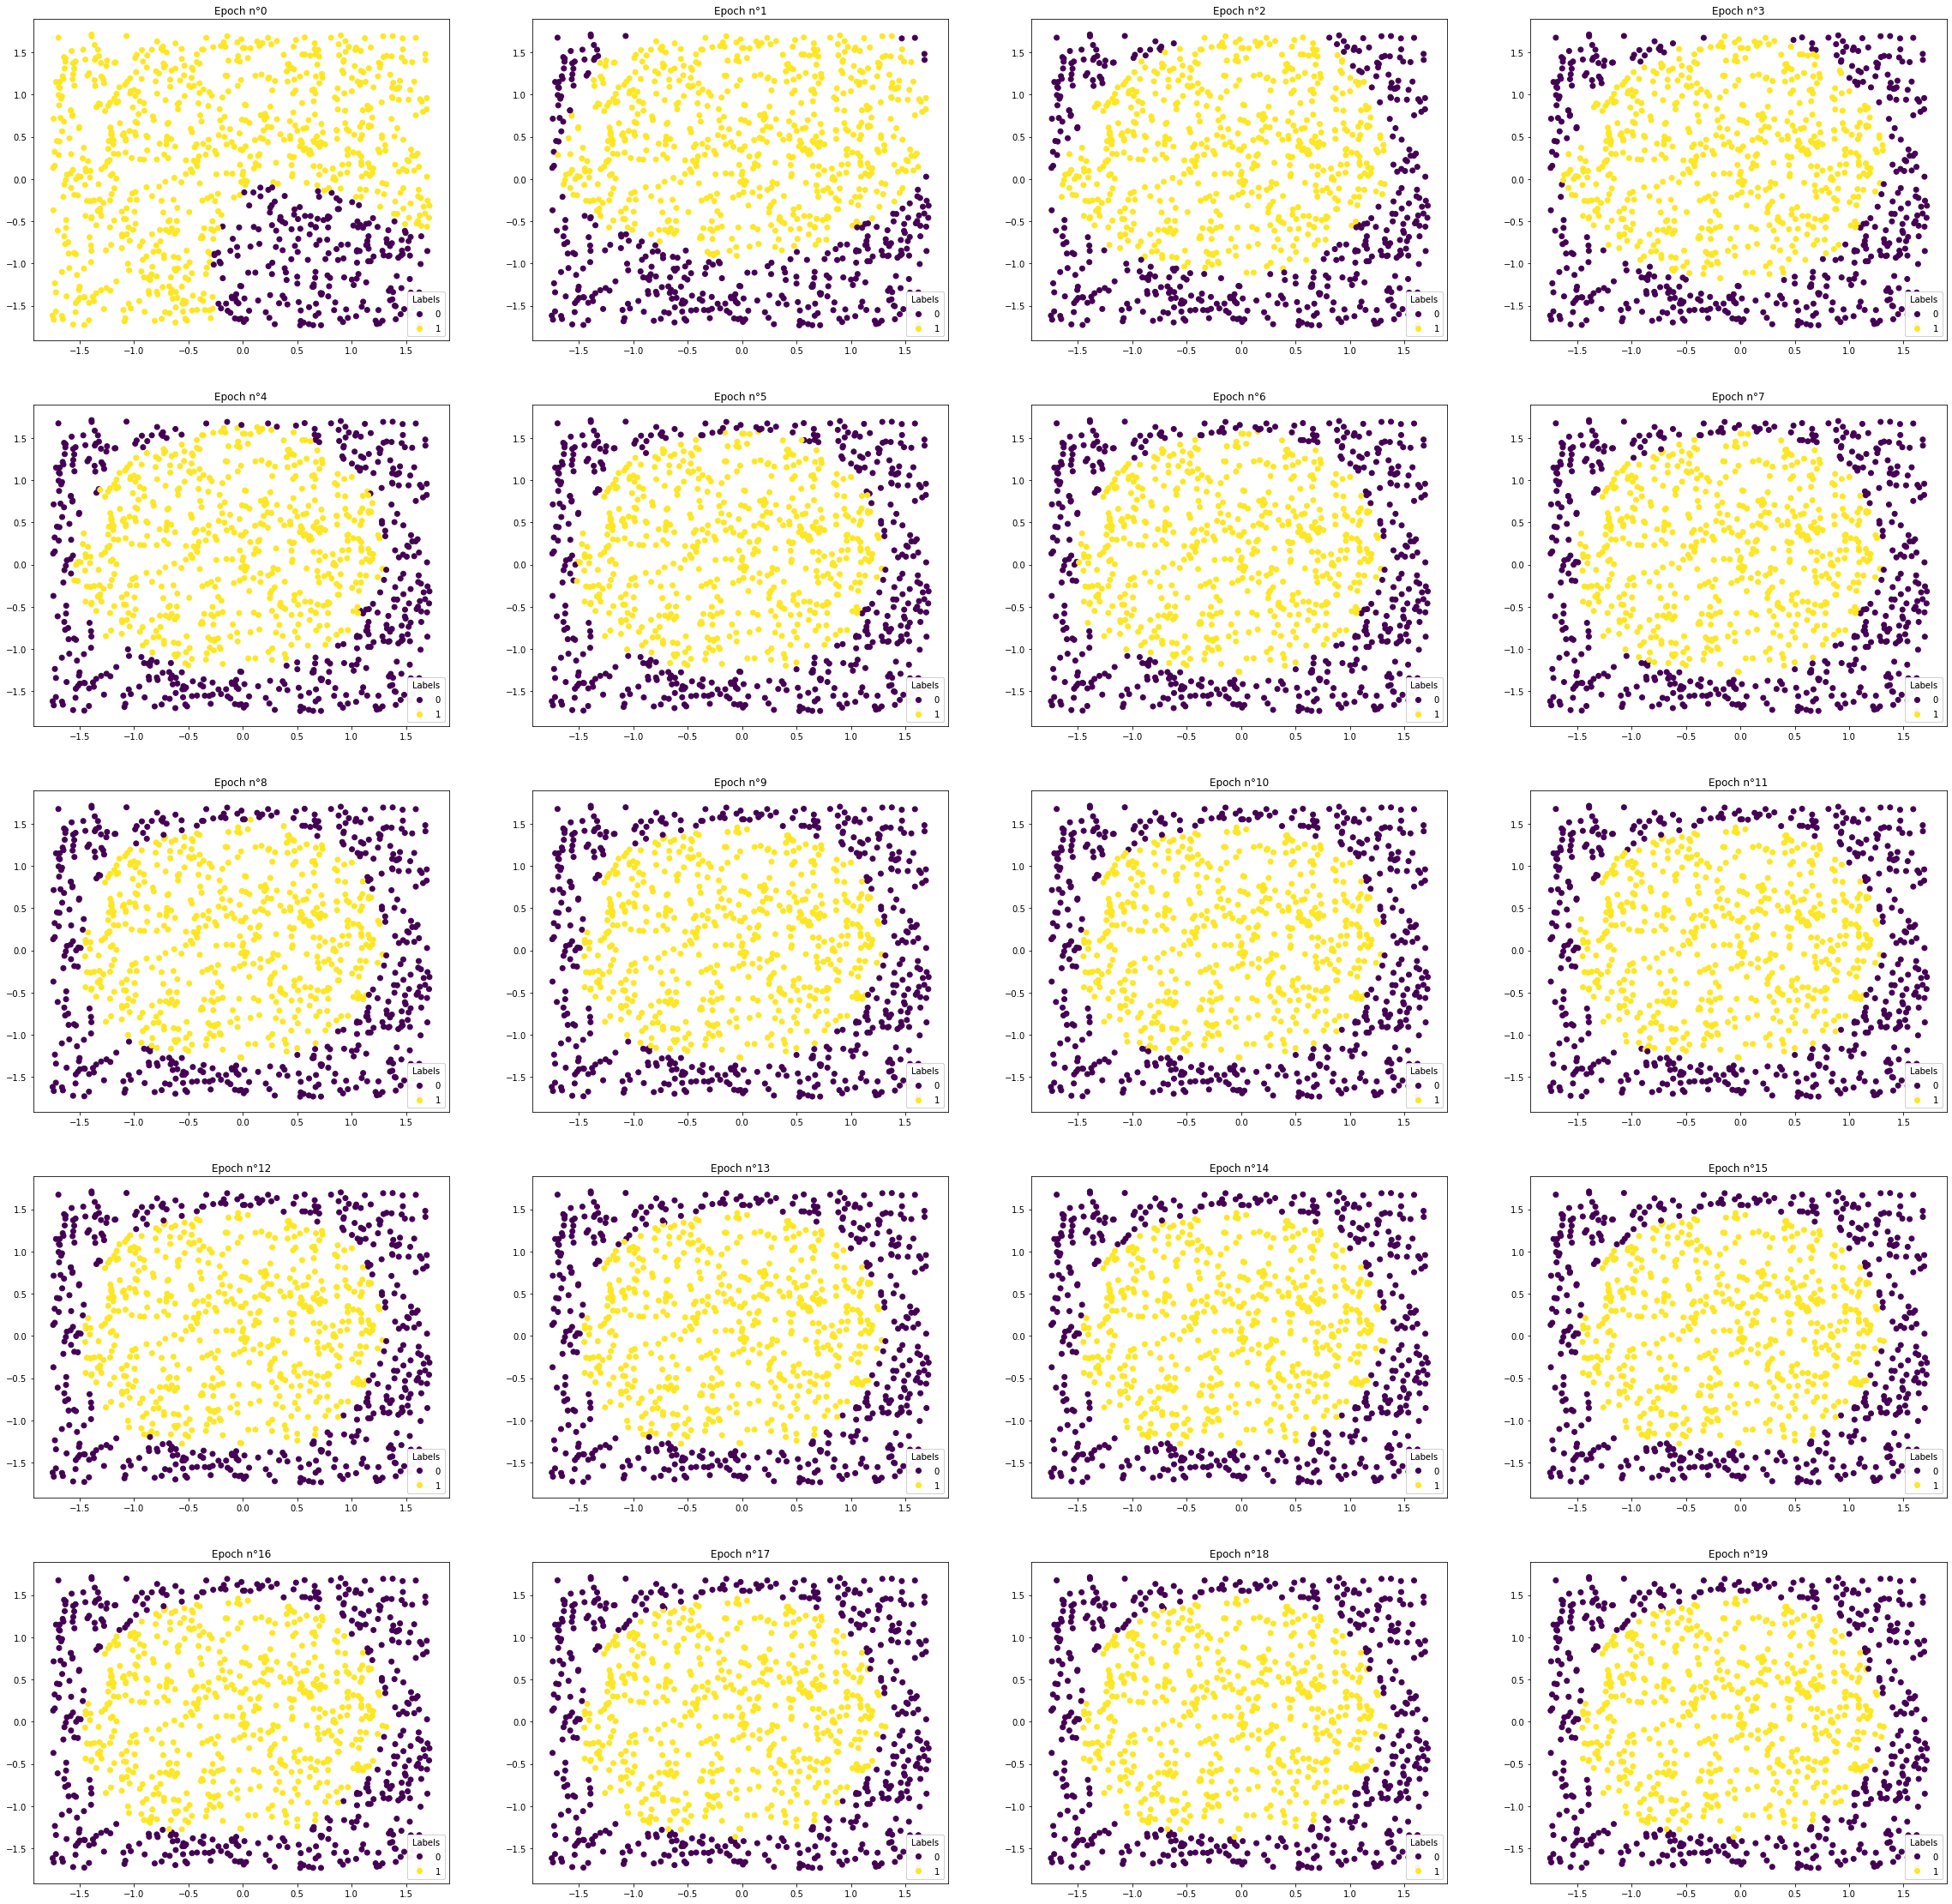

In [52]:
print("LeakyReLU results")
plot_result_evolution(test_features, test_results, 20, 1)

ReLU results


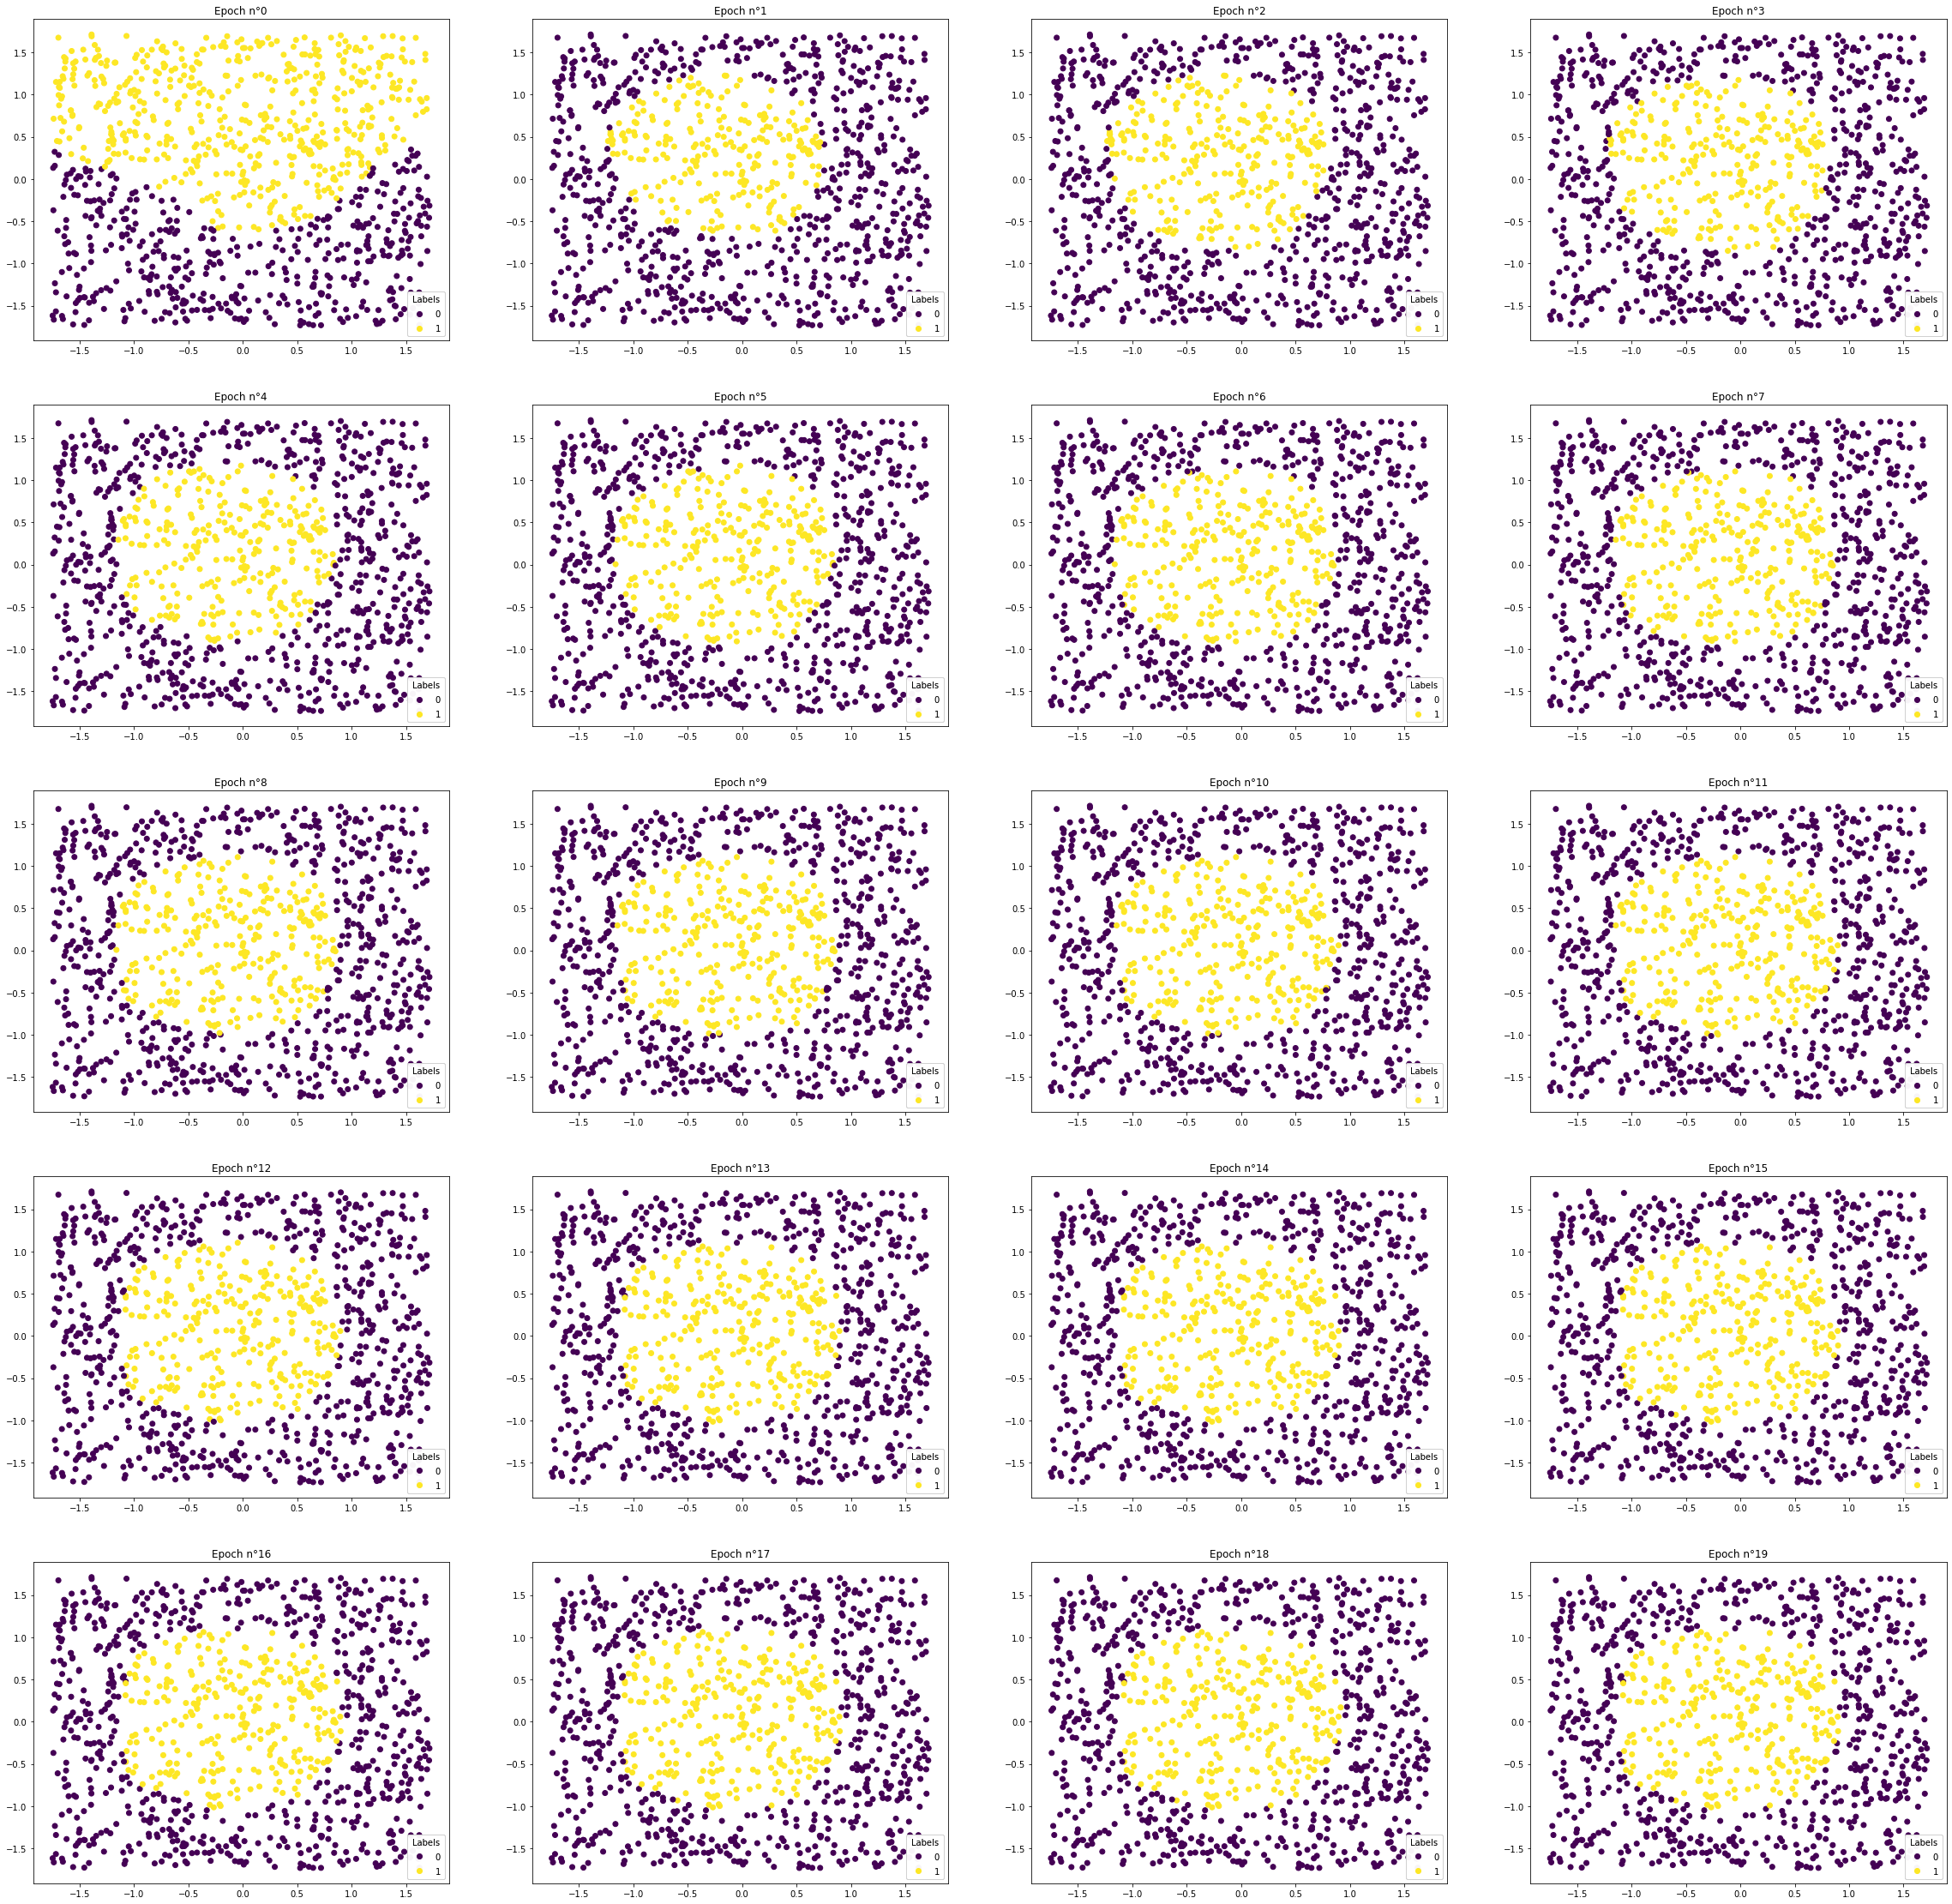

In [50]:
print("ReLU results")
plot_result_evolution(test_features, test_results, 20, 1)

Sigmoid results


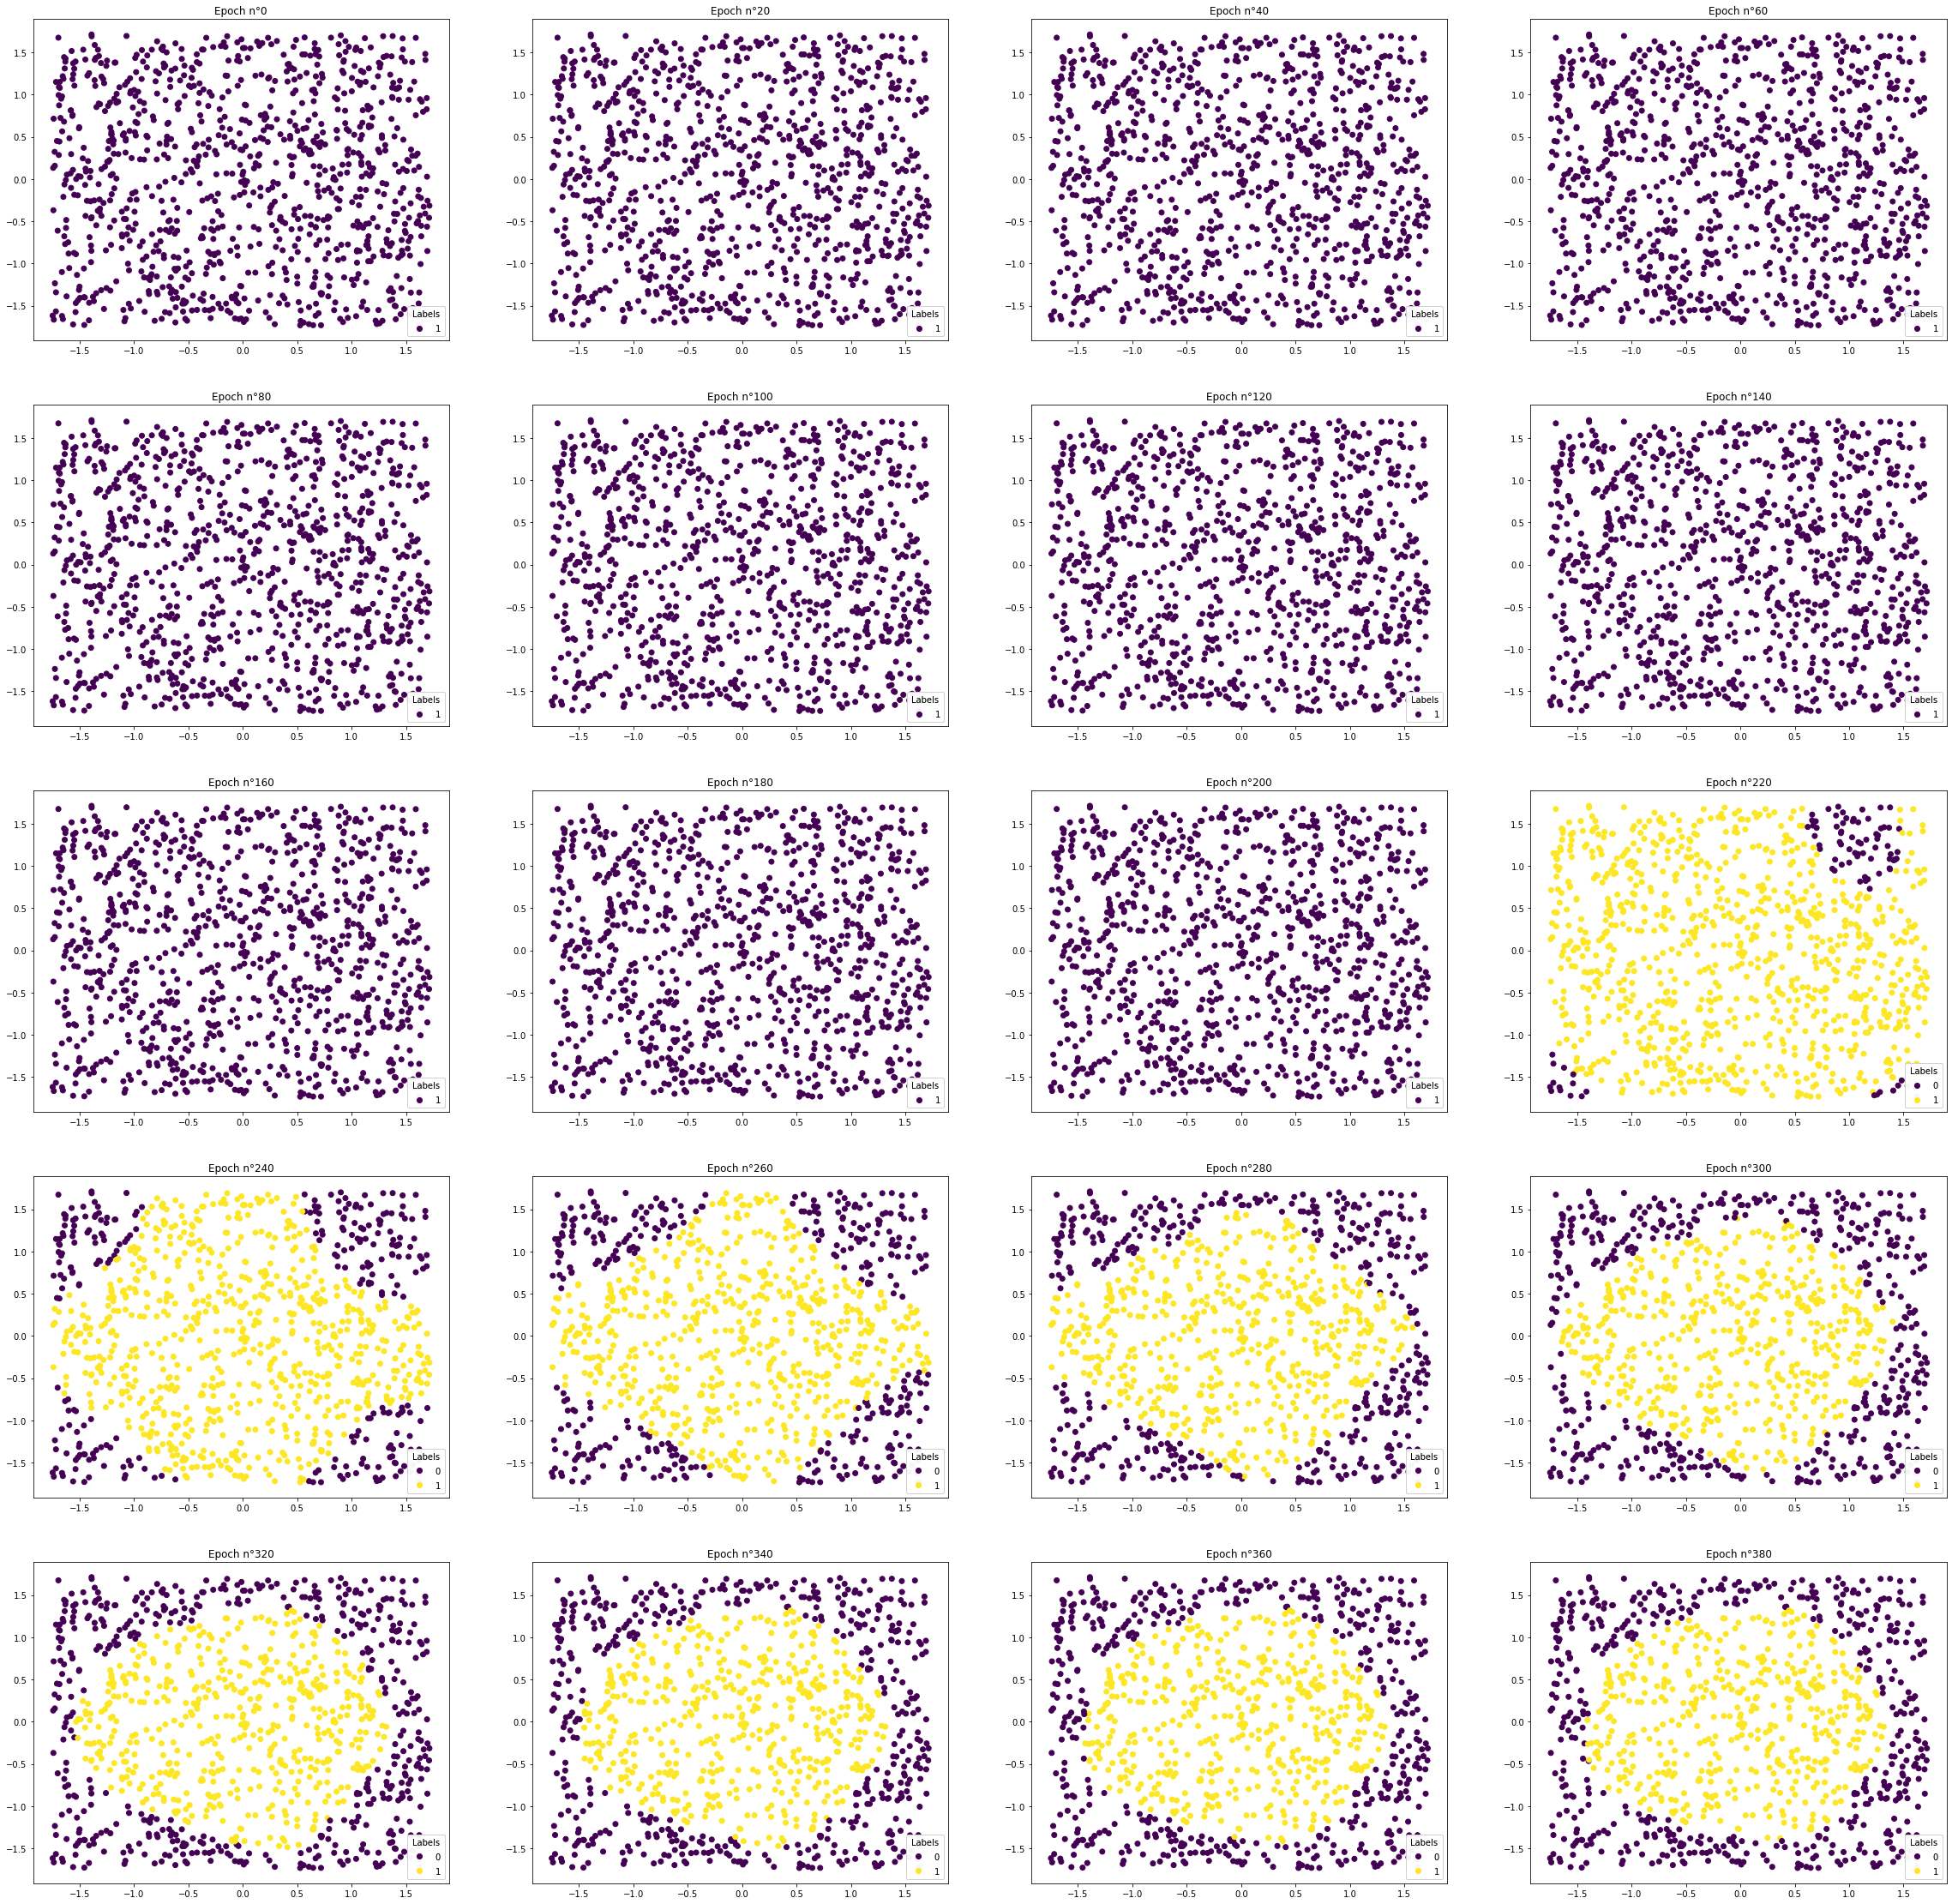

In [48]:
print("Sigmoid results")
plot_result_evolution(test_features, test_results, 400, 20)